## baseline

In [1]:
import nltk
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/manuelcostareis/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [138]:
import pandas as pd
import numpy as np

import re
import string
from numpy import inf

# Baseline 
from collections import Counter, OrderedDict
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import RSLPStemmer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from xgboost import XGBClassifier
from nltk.corpus import stopwords
stop_words = stopwords.words('portuguese')
import warnings; warnings.simplefilter('ignore')


# SKLearn related imports
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn import preprocessing

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.gridspec as gridspec
import spacy

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

random_state = 42

In [136]:

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [46]:
df.Label.unique()

array(['add_to_playlist', 'search_screening_event', 'book_restaurant',
       'rate_book', 'get_weather', 'play_music', 'search_creative_work',
       'no_intent'], dtype=object)

In [155]:
df = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [48]:
df.head()

,Request,Label
0,Adicionar música tomohisa yamashita à minha li...,add_to_playlist
1,Eu quero adicionando Aprite le finestre à minh...,add_to_playlist
2,Que curta-metragens estão tocando às 11 da man...,search_screening_event
3,precisa de uma sala em um que serve foie gras ...,book_restaurant
4,"Atribuir 4 estrelas de 6 para a crônica, Deus ...",rate_book


In [49]:
df.describe()

,Request,Label
count,26527,26799
unique,25752,8
top,Encontre o horário do filme.,no_intent
freq,5,12645


In [50]:
df.Request.iloc[10]

'Toca a melhor música de Phoebe Snow'

In [51]:
nlp = spacy.load('pt_core_news_sm')

In [52]:
def create_aditional_POS_features(_df, text_column_name,_nlp, return_only_new_feats = False):
    n_adj, n_verbs, len_message= [], [], []
    _df_copy = _df.copy()
    n_adv = []
    n_noun = [] 
    
    for doc in _nlp.pipe(_df_copy[text_column_name]):
        n_adj.append(len([token for token in doc if token.pos_ == 'ADJ']))
        if len([token for token in doc if token.pos_ == 'ADJ']) is np.nan:
            print(doc)
            
        n_verbs.append(len([token for token in doc if token.pos_ == 'VERB']))
        
        # Acrescentados adverbs ADV , nouns NOUN
        n_adv.append(len([token for token in doc if token.pos_ == 'ADV']))
        n_noun.append(len([token for token in doc if token.pos_ == 'NOUN']))
        
        len_message.append(len(doc))
    _df_copy['n_adj'] = pd.Series(n_adj)
    _df_copy['n_verbs'] = pd.Series(n_verbs)
    _df_copy['n_adv'] = pd.Series(n_adv)
    _df_copy['n_noun'] = pd.Series(n_noun)
    _df_copy['len_text'] = pd.Series(len_message)
    
    if return_only_new_feats:
        return _df_copy.drop(text_column_name, axis=1)
    else:
        return _df_copy

In [54]:
df = df.dropna()
df = create_aditional_POS_features(df, 'Request', nlp)
df = df.dropna()


## Train Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['Request', 'n_adj', 'n_verbs', 'n_adv', 'n_noun', 'len_text']], df.Label, test_size=0.33, random_state=random_state)

In [63]:
tokenizer = WordPunctTokenizer()
stemmer = RSLPStemmer()
regex_list = [("<[^>]*>", "")]

## Tokenize and Stem

### Tokenize

In [102]:
# Custom transformer to implement sentence cleaning
class PortugueseCleaner(TransformerMixin):
    def __init__(self, tokenizer, stemmer, regex_list,
                 lower=True, remove_punct=True):
        self.tokenizer = tokenizer
        self.stemmer = stemmer
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        X = list(map(self._clean_sentence, X.Request))
        return X
    
    def _clean_sentence(self, sentence):
        # lowercase
        if self.lower:
            sentence = sentence.lower()

        # Split sentence into list of words
        words = self.tokenizer.tokenize(sentence)
            
        # Remove punctuation
        if self.remove_punct:
            words = list(filter(lambda x: x not in string.punctuation, words))

        # Stem words
        if self.stemmer:
            words = map(self.stemmer.stem, words)

        # Join list elements into string
        sentence = " ".join(words)
        
        return sentence
    
    def fit(self, *_):
        return self

## Pipeline

In [103]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [118]:
def pipeliner():
    tokenizer = WordPunctTokenizer()
    stemmer = RSLPStemmer()
    regex_list = [("<[^>]*>", "")]
 

    text = Pipeline([('stemm', PortugueseCleaner(tokenizer, stemmer, regex_list, lower=False)),
                     ('vect', TfidfVectorizer(ngram_range=(1,2))),
                     ('selectKBest', SelectKBest(chi2, k=10000)),
                     ])

    adj =  Pipeline([
                    ('selector', NumberSelector(key='n_adj')),
                    ('standard', StandardScaler())
                ])

    verbs =  Pipeline([
                    ('selector', NumberSelector(key='n_verbs')),
                    ('standard', StandardScaler())
                ])
    
    adv =  Pipeline([
                    ('selector', NumberSelector(key='n_adv')),
                    ('standard', StandardScaler())
                ])

    noun =  Pipeline([
                    ('selector', NumberSelector(key='n_noun')),
                    ('standard', StandardScaler())
                ])
    
    
    len_text =  Pipeline([
                    ('selector', NumberSelector(key='len_text')),
                    ('standard', StandardScaler())
                ])

    feats = FeatureUnion([('Request', text), 
                          ('n_adj', adj),
                          ('n_verbs', verbs),
                          ('n_adv', adv),
                          ('n_noun', noun),
                          ('len_text', len_text)
                           ])

    return Pipeline([('features', feats),
                     ('classifier', XGBClassifier(n_jobs=6, n_estimators=2000))])



## Test

In [119]:
pipe = pipeliner()
# Train the classifier
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('Request', Pipeline(memory=None,
     steps=[('stemm', <__main__.PortugueseCleaner object at 0x11a4c75f8>), ('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encodin...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [120]:
predicted = pipe.predict(X_test)
np.mean(predicted == y_test)

0.9022617124394184

## Submission

In [113]:
df = df.dropna()
df.head()


,Request,Label,n_adj,n_verbs,n_adv,n_noun,len_text
0,Adicionar música tomohisa yamashita à minha li...,add_to_playlist,2.0,1.0,0.0,3.0,12.0
1,Eu quero adicionando Aprite le finestre à minh...,add_to_playlist,0.0,4.0,0.0,1.0,17.0
2,Que curta-metragens estão tocando às 11 da man...,search_screening_event,1.0,2.0,0.0,0.0,14.0
3,precisa de uma sala em um que serve foie gras ...,book_restaurant,1.0,3.0,0.0,4.0,21.0
4,"Atribuir 4 estrelas de 6 para a crônica, Deus ...",rate_book,0.0,1.0,0.0,3.0,16.0


In [114]:
df.describe()

,n_adj,n_verbs,n_adv,n_noun,len_text
count,26259.000000,26259.000000,26259.000000,26259.000000,26259.000000
mean,0.469934,1.840474,0.504665,1.916067,11.871320
std,0.717055,1.393061,0.814602,1.374598,5.141638
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,1.000000,8.000000
50%,0.000000,2.000000,0.000000,2.000000,11.000000
75%,1.000000,3.000000,1.000000,3.000000,14.000000
max,6.000000,12.000000,8.000000,10.000000,44.000000


In [122]:
pipe = pipeliner()
# Train the classifier
pipe.fit(df[['Request', 'n_adj', 'n_verbs', 'n_adv', 'n_noun', 'len_text']], df.Label)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('Request', Pipeline(memory=None,
     steps=[('stemm', <__main__.PortugueseCleaner object at 0x11a1609e8>), ('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encodin...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [127]:
df = create_aditional_POS_features(test, 'Request', nlp)

In [130]:
predicted = pipe.predict(df)
predicted

array(['search_screening_event', 'no_intent', 'search_screening_event',
       ..., 'no_intent', 'no_intent', 'no_intent'], dtype=object)

In [131]:
test['Label'] = predicted
test = test.set_index('Request')

In [132]:
test.to_csv('../data/submission4.csv')

In [153]:
pipe.named_steps['classifier'].DataMatrix

AttributeError: 'XGBClassifier' object has no attribute 'DataMatrix'

NameError: name 'importance' is not defined

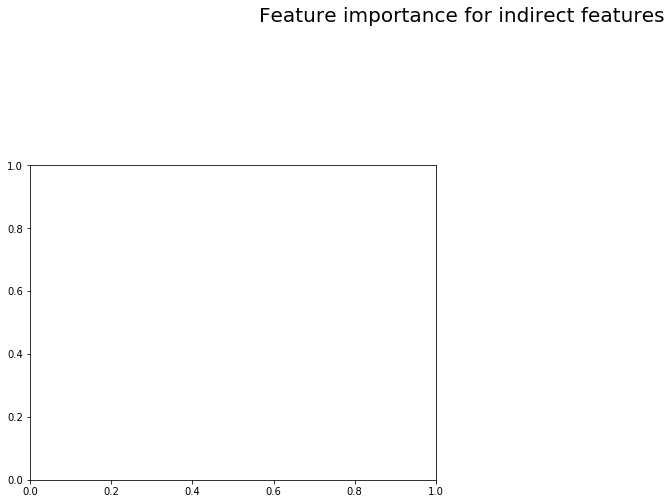

In [139]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot([['n_verbs', 'n_adv', 'n_adj', ]],importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

In [156]:
df[df.Label == 'no_intent']

,Request,Label
47,qual é a previsão para quente às dez em Idaho,no_intent
101,Eu preciso falar a música Aspro Mavro de Bill ...,no_intent
107,Toque uma música de 1973.,no_intent
110,Onde posso contar o late-night? Twentysomething,no_intent
137,Eu preciso de uma área em Steele City,no_intent
143,adicionar música ao meu El Mejor Pop en Español,no_intent
155,Eu quero adici Kiara à minha lista de reproduç...,no_intent
159,aval a maestria sem esforço crônica a 4,no_intent
164,materializar uma chamada Quanto Madeira seria ...,no_intent
169,Coloque esta música no remix de treino,no_intent
